[CudaDevice(id=0)]
gpu
(10, 100, 1)
(10, 100, 1)
Epoch 1, Train loss = 2.6282, Test loss = 2.3213
Epoch 11, Train loss = 0.3642, Test loss = 0.3542
Epoch 21, Train loss = 0.3473, Test loss = 0.3672
Epoch 31, Train loss = 0.3585, Test loss = 0.3399
Epoch 41, Train loss = 0.3587, Test loss = 0.3422
Epoch 51, Train loss = 0.3474, Test loss = 0.3432
Epoch 61, Train loss = 0.3686, Test loss = 0.3602
Epoch 71, Train loss = 0.3692, Test loss = 0.3410
Epoch 81, Train loss = 0.3557, Test loss = 0.3433
Epoch 91, Train loss = 0.3435, Test loss = 0.3390


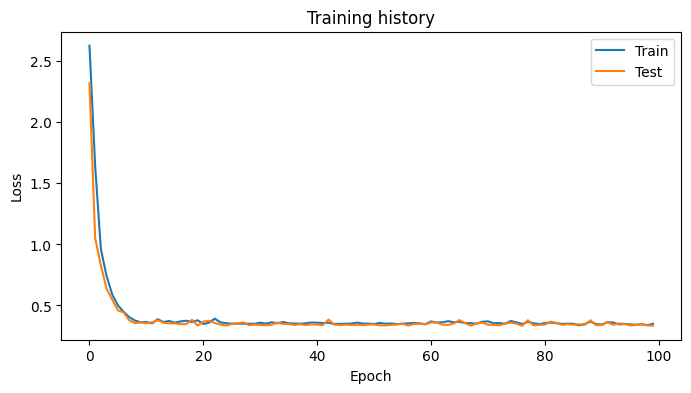

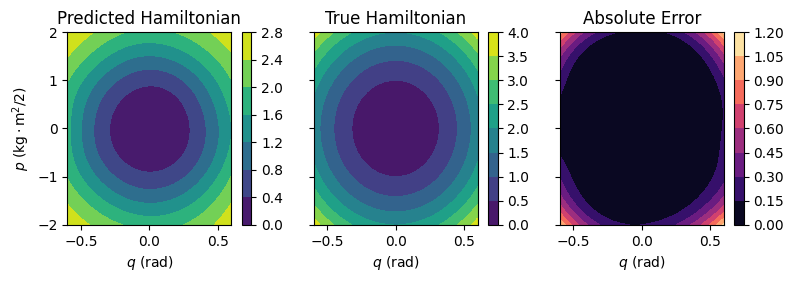

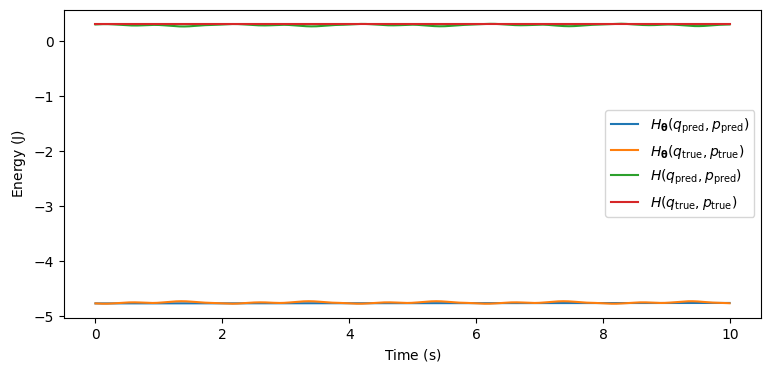

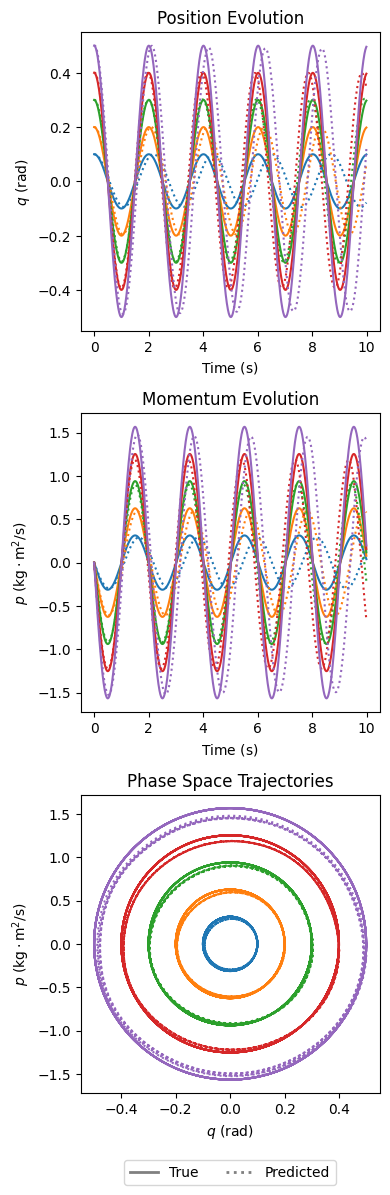

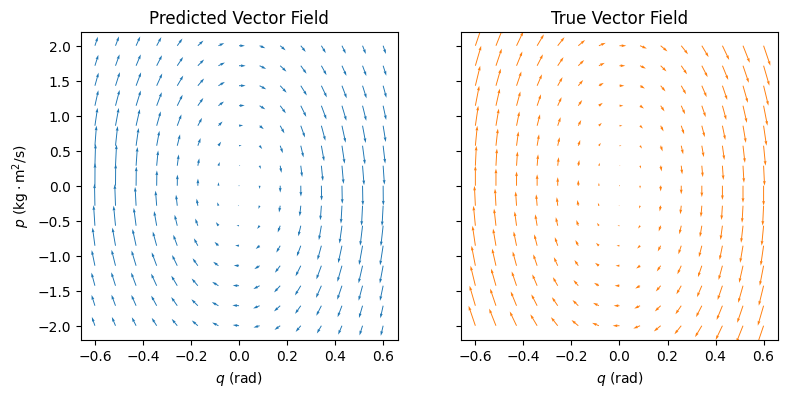

In [50]:
import jax
from jax import numpy as jnp
from flax import nnx
import optax
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed = 123
rngs = nnx.Rngs(seed)
# Check available devices and the default backend
print(jax.devices())
print(jax.default_backend())

class HNN(nnx.Module):

    def __init__(self, system_dim, hidden_features, *, rngs):
        super().__init__()
        self.layers = []
        in_features = 2 * system_dim
        for out_features in hidden_features:
            self.layers.append(nnx.Linear(in_features, out_features, rngs=rngs))
            in_features = out_features

        self.layers.append(nnx.Linear(in_features, 1, rngs=rngs))

    def __call__(self, q, p):
        q, p = jnp.atleast_1d(q, p)
        z = jnp.concatenate([q, p], axis=-1)
        for layer in self.layers[:-1]:
            z = nnx.tanh(layer(z))

        h = self.layers[-1](z)

        return h.squeeze(-1)

    def symplectic_grad(self, q, p):
        dot_q = jax.vmap(jax.grad(self.__call__, argnums=1))(q, p)
        dot_p = -jax.vmap(jax.grad(self.__call__, argnums=0))(q, p)

        return dot_q, dot_p

    def solve_ivp(self, q_0, p_0, t_span, *args, **kwargs):
        def f(t, z):
            q, p = jnp.split(z, 2, axis=-1)
            dot_q, dot_p = self.symplectic_grad(q, p)
            dot_z = jnp.concatenate([dot_q, dot_p], axis=-1)

            return dot_z

        q_0, p_0 = jnp.atleast_1d(q_0, p_0)
        z_0 = jnp.concatenate([q_0, p_0], axis=-1)
        sol = solve_ivp(f, t_span, z_0, *args, **kwargs)
        t, z = sol.t, sol.y.T
        q, p = np.split(z, 2, axis=-1)

        return t, q, p

def loss_fn(hnn, batch):
    (q, p), (dot_q, dot_p) = batch
    dot_q_pred, dot_p_pred = hnn.symplectic_grad(q, p)
    loss = jnp.mean((dot_q_pred - dot_q)**2 + (dot_p_pred - dot_p)**2)

    return loss
@nnx.jit
def train_step(model, optimizer, metrics, batch):
    model.train()
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model, batch)
    metrics.update(values=loss)
    optimizer.update(grads)

@nnx.jit
def eval_step(model, metrics, batch):
    model.eval()
    loss = loss_fn(model, batch)
    metrics.update(values=loss)

def batch_iterator(z, dot_z, batch_size, shuffle=True):
    q = z[0].reshape(-1, z[0].shape[-1])
    p = z[1].reshape(-1, z[1].shape[-1])
    dot_q = dot_z[0].reshape(-1, dot_z[0].shape[-1])
    dot_p = dot_z[1].reshape(-1, dot_z[1].shape[-1])

    n_samples = q.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = start + batch_size
        if end > n_samples:
            break  # Drop incomplete batch

        batch = indices[start:end]
        yield (q[batch], p[batch]), (dot_q[batch], dot_p[batch])

def print_logs(epoch, history, period=10):
    if epoch % period == 0:
        logs = []
        for k, v in history.items():
            key = k.replace('_', ' ').capitalize()
            value = f'{v[-1]:.4f}'
            logs.append(' = '.join([key, value]))

        print(f'Epoch {epoch + 1}', *logs, sep=', ')

def train(
    model,
    optimizer,
    z_train,
    dot_z_train,
    z_test,
    dot_z_test,
    epochs,
    batch_size=32
):
    history = {'train_loss': [], 'test_loss': []}
    metrics = nnx.MultiMetric(loss=nnx.metrics.Average())
    for epoch in range(epochs):
        # Training
        for batch in batch_iterator(z_train, dot_z_train, batch_size, shuffle=True):
            train_step(model, optimizer, metrics, batch)

        for metric, value in metrics.compute().items():
            history[f'train_{metric}'].append(value)

        metrics.reset()  # Reset the metrics for the test set.

        # Evaluation
        for batch in batch_iterator(z_test, dot_z_test, batch_size, shuffle=False):
            eval_step(model, metrics, batch)

        for metric, value in metrics.compute().items():
            history[f'test_{metric}'].append(value)

        metrics.reset()  # Reset the metrics for the next training epoch.
        print_logs(epoch, history)

    return history

l = 1.0  # length (m)
m = 1.0  # mass (kg)
g = 9.81  # gravity (m/s^2)
omega = jnp.sqrt(g / l)  # natural frequency (s^{-1})

@jax.vmap
def pendulum_hamiltonian(q, p):
    T = p**2 / (2 * m * l**2)
    V = m * g * l * q**2 / 2
    H = T + V

    return H

def pendulum_kinematics(t, q_0, dot_q_0):
    q = q_0 * jnp.cos(omega * t) + (dot_q_0 / omega) * jnp.sin(omega * t)
    dot_q = -q_0 * omega * jnp.sin(omega * t) + dot_q_0 * jnp.cos(omega * t)
    p = m * l**2 * dot_q
    dot_p = -m * g * l * q

    return q, p, dot_q, dot_p

# Vectorize in t
pendulum_kinematics = jax.vmap(pendulum_kinematics, in_axes=(0, None, None))

def simulate_experiment(n_trajectories, n_points, duration, noise_std=0.01, seed=123):
    np.random.seed(seed)
    t = np.linspace(0, duration, n_points)
    dt = t[1] - t[0]
    q_0 = np.random.uniform(-0.5, 0.5, (n_trajectories, 1))
    dot_q_0 = np.zeros((n_trajectories, 1))
    q = np.empty((n_trajectories, n_points, 1))
    # Generate clean analytical solutions
    for i in range(n_trajectories):
        q[i], _, _, _ = pendulum_kinematics(t, q_0[i], dot_q_0[i])

    # Add noise to position measurements (simulating real experiments)
    q = q + np.random.normal(0, noise_std, q.shape)
    # Compute velocity using finite differences
    dot_q = np.gradient(q, dt, axis=1)
    # Compute momentum and its derivative
    p = m * l**2 * dot_q
    dot_p = np.gradient(p, dt, axis=1)

    return t, (q, p), (dot_q, dot_p)

t_train, z_train, dot_z_train = simulate_experiment(10, 100, 10, seed=seed)
t_test, z_test, dot_z_test = simulate_experiment(10, 100, 10, seed=seed)

print(z_train[0].shape)
print(z_test[0].shape)

model = HNN(system_dim=1, hidden_features=[64, 64, 64], rngs=rngs)
optimizer = nnx.Optimizer(model, optax.adam(1e-3))

history = train(
    model, optimizer, z_train, dot_z_train, z_test, dot_z_test, epochs=100
)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history['train_loss'], label='Train')
ax.plot(history['test_loss'], label='Test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Training history')

plt.show()

# Create a grid for visualization
q_grid = jnp.linspace(-0.6, 0.6, 50)
p_grid = jnp.linspace(-2.0, 2.0, 50)
Q, P = jnp.meshgrid(q_grid, p_grid)

# Flatten for batch evaluation
q = Q.reshape(-1, 1)
p = P.reshape(-1, 1)

# Compute Hamiltonians
H_pred = model(q, p).reshape(Q.shape)
H_true = pendulum_hamiltonian(q, p).reshape(Q.shape)
# Place the minimun energy at 0 in both cases to compare
H_pred = H_pred - np.min(H_pred)
H_true = H_true - np.min(H_true)
abs_error = jnp.abs(H_pred - H_true)

# Create 2D contour plots
fig, axes = plt.subplots(1, 3, figsize=(9, 2.5), sharex=True, sharey=True)

# Learned Hamiltonian plot
cf1 = axes[0].contourf(Q, P, H_pred, cmap='viridis')
axes[0].set_xlabel(r'$q$ ($\mathrm{rad}$)')
axes[0].set_ylabel(r'$p$ ($\mathrm{kg\cdot m^2/2}$)')
axes[0].set_title('Predicted Hamiltonian')
fig.colorbar(cf1, ax=axes[0])

# True Hamiltonian plot
cf2 = axes[1].contourf(Q, P, H_true, cmap='viridis')
axes[1].set_xlabel(r'$q$ ($\mathrm{rad}$)')
axes[1].set_title('True Hamiltonian')
fig.colorbar(cf2, ax=axes[1])

# Absolute error plot
cf3 = axes[2].contourf(Q, P, abs_error, cmap='magma')
axes[2].set_xlabel(r'$q$ ($\mathrm{rad}$)')
axes[2].set_title('Absolute Error')
fig.colorbar(cf3, ax=axes[2])

plt.show()

q_0 = np.random.uniform(-0.5, 0.5, (1,))
dot_q_0 = p_0 = np.zeros((1,))
duration = 10.0  # Long integration to test stability
dt = 0.01

t = np.arange(0, duration, dt)
# Compute the predicted trajectory
t, q_pred, p_pred = model.solve_ivp(q_0, p_0, (0, duration), t_eval=t)
# Also get analytical solution for comparison
q_true, p_true, _, _ = pendulum_kinematics(t, q_0, dot_q_0)

# Compute energy along trajectory
energy_pred_for_trajectory_pred = model(q_pred, p_pred)
energy_pred_for_trajectory_true = model(q_true, p_true)
energy_true_for_trajectory_pred = pendulum_hamiltonian(q_pred, p_pred)
energy_true_for_trajectory_true = pendulum_hamiltonian(q_true, p_true)

fig, ax = plt.subplots(figsize=(9, 4))
results = {
    r'$H_{\mathbf{\theta}}(q_{\text{pred}}, p_{\text{pred}})$': energy_pred_for_trajectory_pred,
    r'$H_{\mathbf{\theta}}(q_{\text{true}}, p_{\text{true}})$': energy_pred_for_trajectory_true,
    r'$H(q_{\text{pred}}, p_{\text{pred}})$': energy_true_for_trajectory_pred,
    r'$H(q_{\text{true}}, p_{\text{true}})$': energy_true_for_trajectory_true
}

for label, energy in results.items():
    ax.plot(t, energy, label=label)

ax.set_xlabel(r'Time ($\mathrm{s}$)')
ax.set_ylabel(r'Energy ($\mathrm{J}$)')
ax.legend()

plt.show()

from matplotlib.lines import Line2D

n_tests = 5
q_0 = np.linspace(0.1, 0.5, n_tests).reshape(-1, 1)
dot_q_0 = p_0 = np.zeros((n_tests, 1))
duration = 10.0  # Long integration to test stability
dt = 0.01
t = np.arange(0, duration, dt)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axes = plt.subplots(3, 1, figsize=(4, 12))

for i in range(n_tests):
    # Integrate with HNN
    t, q_pred, p_pred = model.solve_ivp(q_0[i], p_0[i], (0, duration), t_eval=t)
    # Get analytical solution
    q_true, p_true, _, _ = pendulum_kinematics(t, q_0[i], dot_q_0[i])

    # Plot trajectories
    axes[0].plot(t, q_pred.squeeze(), linestyle='dotted', color=colors[i])
    axes[0].plot(t, q_true.squeeze(), color=colors[i])

    axes[1].plot(t, p_pred.squeeze(), linestyle='dotted',  color=colors[i])
    axes[1].plot(t, p_true.squeeze(), color=colors[i])

    # Phase space
    axes[2].plot(q_pred.squeeze(), p_pred.squeeze(), linestyle='dotted',  color=colors[i])
    axes[2].plot(q_true.squeeze(), p_true.squeeze(), color=colors[i])

axes[0].set_xlabel(r'Time ($\mathrm{s}$)')
axes[0].set_ylabel(r'$q$ ($\mathrm{rad}$)')
axes[0].set_title('Position Evolution')

axes[1].set_xlabel(r'Time ($\mathrm{s}$)')
axes[1].set_ylabel(r'$p$ ($\mathrm{kg\cdot m^2/s}$)')
axes[1].set_title('Momentum Evolution')

axes[2].set_xlabel(r'$q$ ($\mathrm{rad}$)')
axes[2].set_ylabel(r'$p$ ($\mathrm{kg\cdot m^2/s}$)')
axes[2].set_title('Phase Space Trajectories')

# Custom legend elements
legend_elements = [
    Line2D([0], [0], color='grey', lw=2, linestyle='-', label='True'),
    Line2D([0], [0], color='grey', lw=2, linestyle='dotted', label='Predicted')
]

# Add figure-level legend below the subplots
axes[2].legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=2
)

# Adjust layout to make space for legend
plt.tight_layout()
plt.show()

# Create a grid for visualization
q_grid = jnp.linspace(-0.6, 0.6, 15)
p_grid = jnp.linspace(-2.0, 2.0, 15)
Q, P = jnp.meshgrid(q_grid, p_grid)

# Flatten for batch evaluation
q = Q.reshape(-1, 1)
p = P.reshape(-1, 1)

# HNN vector field
dot_q_pred, dot_p_pred = model.symplectic_grad(q, p)
dot_q_pred = dot_q_pred.reshape(Q.shape)
dot_p_pred = dot_p_pred.reshape(Q.shape)

# True vector field
dot_q_true = P / (m * l**2)
dot_p_true = -m * g * l * Q

# Plot
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Learned vector field
axes[0].quiver(Q, P, dot_q_pred, dot_p_pred, color=colors[0], width=0.003)
axes[0].set_xlabel(r'$q$ ($\mathrm{rad}$)')
axes[0].set_ylabel(r'$p$ ($\mathrm{kg\cdot m^2/s}$)')
axes[0].set_title('Predicted Vector Field')

# True vector field
axes[1].quiver(Q, P, dot_q_true, dot_p_true, color=colors[1], width=0.003)
axes[1].set_xlabel(r'$q$ ($\mathrm{rad}$)')
axes[1].set_title('True Vector Field')

plt.show()

In [ ]:
import jax
from jax import numpy as jnp
from flax import nnx
import optax
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Set random seed for reproducibility
seed = 42
rngs = nnx.Rngs(seed)

# Check available devices and the default backend
print(f"JAX devices: {jax.devices()}")
print(f"JAX default backend: {jax.default_backend()}")

class HNN(nnx.Module):
    """Hamiltonian Neural Network."""

    def __init__(self, system_dim, hidden_features, *, rngs):
        """
        Initializes the HNN.

        Args:
            system_dim: The dimension of the system's configuration space (e.g., 2 for 2D motion).
            hidden_features: A list of integers specifying the number of neurons in each hidden layer.
            rngs: The random number generators for weight initialization.
        """
        super().__init__()
        self.system_dim = system_dim
        self.layers = []
        # The input to the network is the phase space vector (q, p), so its dimension is 2 * system_dim
        in_features = 2 * system_dim
        for out_features in hidden_features:
            self.layers.append(nnx.Linear(in_features, out_features, rngs=rngs))
            in_features = out_features

        # The output is the scalar Hamiltonian
        self.layers.append(nnx.Linear(in_features, 1, rngs=rngs))

    def __call__(self, q, p):
        """
        Computes the learned Hamiltonian for a given state (q, p).

        Args:
            q: Generalized coordinates (position). Shape (..., system_dim).
            p: Generalized momenta. Shape (..., system_dim).

        Returns:
            The scalar value of the learned Hamiltonian.
        """
        q, p = jnp.atleast_1d(q, p)
        # Ensure q and p have the correct trailing dimension if they are single vectors
        if q.ndim == 1 and q.shape[0] == self.system_dim:
             q = q.reshape(1, -1)
             p = p.reshape(1, -1)

        z = jnp.concatenate([q, p], axis=-1)
        for layer in self.layers[:-1]:
            z = nnx.tanh(layer(z))

        h = self.layers[-1](z)
        return h.squeeze(-1)

    def symplectic_grad(self, q, p):
        """
        Computes the time derivatives (dot_q, dot_p) using the learned Hamiltonian.
        This enforces Hamilton's equations: dot_q = dH/dp, dot_p = -dH/dq.
        """
        # jax.vmap is used to handle batches of states.
        dot_q = jax.vmap(jax.grad(self.__call__, argnums=1))(q, p)
        dot_p = -jax.vmap(jax.grad(self.__call__, argnums=0))(q, p)
        return dot_q, dot_p

    def solve_ivp(self, q_0, p_0, t_span, *args, **kwargs):
        """
        Numerically integrates the trajectory using the learned Hamiltonian dynamics.
        """
        def dynamics_fn(t, z):
            """The ODE system defined by the learned Hamiltonian."""
            q, p = jnp.split(z, 2, axis=-1)
            # Reshape for the model if necessary
            q = q.reshape(1, -1)
            p = p.reshape(1, -1)
            dot_q, dot_p = self.symplectic_grad(q, p)
            dot_z = jnp.concatenate([dot_q, dot_p], axis=-1)
            return dot_z.flatten()

        q_0, p_0 = jnp.atleast_1d(q_0, p_0), jnp.atleast_1d(p_0, p_0)
        z_0 = jnp.concatenate([q_0, p_0], axis=-1)

        sol = solve_ivp(dynamics_fn, t_span, z_0, *args, **kwargs)
        t, z = sol.t, sol.y.T
        q, p = np.split(z, 2, axis=-1)
        return t, q, p

def loss_fn(hnn, batch):
    """Computes the mean squared error loss between predicted and true derivatives."""
    (q, p), (dot_q, dot_p) = batch
    dot_q_pred, dot_p_pred = hnn.symplectic_grad(q, p)
    loss = jnp.mean((dot_q_pred - dot_q)**2 + (dot_p_pred - dot_p)**2)
    return loss

@nnx.jit
def train_step(model, optimizer, metrics, batch):
    """Performs a single training step."""
    model.train()
    grad_fn = nnx.value_and_grad(loss_fn)
    loss, grads = grad_fn(model, batch)
    metrics.update(values=loss)
    optimizer.update(grads)

@nnx.jit
def eval_step(model, metrics, batch):
    """Performs a single evaluation step."""
    model.eval()
    loss = loss_fn(model, batch)
    metrics.update(values=loss)

def batch_iterator(z, dot_z, batch_size, shuffle=True):
    """Creates a batch iterator for the training data."""
    q = z[0].reshape(-1, z[0].shape[-1])
    p = z[1].reshape(-1, z[1].shape[-1])
    dot_q = dot_z[0].reshape(-1, dot_z[0].shape[-1])
    dot_p = dot_z[1].reshape(-1, dot_z[1].shape[-1])

    n_samples = q.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        end = start + batch_size
        if end > n_samples:
            break  # Drop incomplete batch
        batch_indices = indices[start:end]
        yield (q[batch_indices], p[batch_indices]), (dot_q[batch_indices], dot_p[batch_indices])

def print_logs(epoch, history, period=10):
    if epoch % period == 0 or epoch == epochs - 1:
        logs = []
        for k, v in history.items():
            key = k.replace('_', ' ').capitalize()
            value = f'{v[-1]:.4f}'
            logs.append(' = '.join([key, value]))
        print(f'Epoch {epoch + 1}', *logs, sep=', ')

def train(model, optimizer, z_train, dot_z_train, z_test, dot_z_test, epochs, batch_size=32):
    history = {'train_loss': [], 'test_loss': []}
    metrics = nnx.MultiMetric(loss=nnx.metrics.Average())
    for epoch in range(epochs):
        # Training
        for batch in batch_iterator(z_train, dot_z_train, batch_size, shuffle=True):
            train_step(model, optimizer, metrics, batch)
        for metric, value in metrics.compute().items():
            history[f'train_{metric}'].append(value)
        metrics.reset()

        # Evaluation
        for batch in batch_iterator(z_test, dot_z_test, batch_size, shuffle=False):
            eval_step(model, metrics, batch)
        for metric, value in metrics.compute().items():
            history[f'test_{metric}'].append(value)
        metrics.reset()

        print_logs(epoch, history, epochs=epochs)
    return history

# --- System Definition: Charged Particle in a Magnetic Field ---
m = 1.0  # mass
e = 1.0  # charge
B_z = 1.0  # magnetic field strength in z-direction

def charged_particle_hamiltonian(q, p):
    """Computes the true Hamiltonian for a charged particle in a magnetic field."""
    x, y = q[..., 0], q[..., 1]
    px, py = p[..., 0], p[..., 1]

    # Magnetic vector potential A in symmetric gauge: A = 0.5 * B x r
    Ax = -0.5 * B_z * y
    Ay = 0.5 * B_z * x

    # Kinetic momentum P = p - eA
    Px = px - e * Ax
    Py = py - e * Ay

    # Hamiltonian H = P^2 / (2m)
    H = (Px**2 + Py**2) / (2 * m)
    return H

def charged_particle_dynamics(t, z):
    """
    Defines the ODE for the charged particle's motion via Hamilton's equations.
    This is used to generate the ground truth data.
    z = [x, y, px, py]
    """
    q, p = z[:2], z[2:]

    # Using jax.grad to get derivatives of the true Hamiltonian
    H_grad_p = jax.grad(charged_particle_hamiltonian, argnums=1)(q, p)
    H_grad_q = jax.grad(charged_particle_hamiltonian, argnums=0)(q, p)

    dot_q = H_grad_p
    dot_p = -H_grad_q

    return np.concatenate([dot_q, dot_p])

def simulate_particle_motion(n_trajectories, n_points, duration, noise_std=0.01, seed=123):
    """Generates trajectory data for the charged particle."""
    np.random.seed(seed)
    t = np.linspace(0, duration, n_points)
    dt = t[1] - t[0]

    # Initial conditions: random positions and momenta
    q_0 = np.random.uniform(-1, 1, (n_trajectories, 2))
    p_0 = np.random.uniform(-1, 1, (n_trajectories, 2))

    q_all, p_all = [], []
    dot_q_all, dot_p_all = [], []

    for i in range(n_trajectories):
        z0 = np.concatenate([q_0[i], p_0[i]])
        sol = solve_ivp(charged_particle_dynamics, [t[0], t[-1]], z0, t_eval=t, rtol=1e-10, atol=1e-10)

        q, p = sol.y[:2, :].T, sol.y[2:, :].T

        # Calculate derivatives from the dynamics function
        dot_z = np.array([charged_particle_dynamics(ti, zi) for ti, zi in zip(t, sol.y.T)])
        dot_q, dot_p = dot_z[:, :2], dot_z[:, 2:]

        q_all.append(q)
        p_all.append(p)
        dot_q_all.append(dot_q)
        dot_p_all.append(dot_p)

    q, p = np.array(q_all), np.array(p_all)
    dot_q, dot_p = np.array(dot_q_all), np.array(dot_p_all)

    # Add noise to measurements
    q_noisy = q + np.random.normal(0, noise_std, q.shape)
    p_noisy = p + np.random.normal(0, noise_std, p.shape)

    # We use the noisy positions and momenta as input, and the true derivatives as targets
    # This simulates a scenario where we have noisy measurements of the state
    return t, (q_noisy, p_noisy), (dot_q, dot_p), (q, p)

# --- Main Execution ---
# Simulation parameters
system_dim = 2
epochs = 100
lr = 1e-3
batch_size = 64

# Generate Data
t_train, z_train, dot_z_train, _ = simulate_particle_motion(20, 100, 10, noise_std=0.05, seed=seed)
t_test, z_test, dot_z_test, z_true_test = simulate_particle_motion(5, 100, 10, noise_std=0.05, seed=seed+1)

print(f"Train data q shape: {z_train[0].shape}")
print(f"Test data q shape: {z_test[0].shape}")

# Initialize Model and Optimizer
model = HNN(system_dim=system_dim, hidden_features=[128, 128], rngs=rngs)
optimizer = nnx.Optimizer(model, optax.adam(lr))

# Train the model
history = train(
    model, optimizer, z_train, dot_z_train, z_test, dot_z_test, epochs=epochs, batch_size=batch_size
)

# --- Visualization ---

# 1. Plot Training History
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history['train_loss'], label='Train Loss')
ax.plot(history['test_loss'], label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_yscale('log')
ax.legend()
ax.set_title('Training and Test Loss Over Epochs')
plt.show()

# 2. Compare predicted and true trajectories
n_tests = 3
q_0 = z_true_test[0][:n_tests, 0, :]  # Initial positions from test set
p_0 = z_true_test[1][:n_tests, 0, :]  # Initial momenta from test set
duration = 15.0
t_eval = np.linspace(0, duration, 300)

fig, axes = plt.subplots(1, n_tests, figsize=(15, 5))
if n_tests == 1: axes = [axes] # Ensure axes is iterable

for i in range(n_tests):
    # Integrate with HNN
    t_pred, q_pred, p_pred = model.solve_ivp(q_0[i], p_0[i], (0, duration), t_eval=t_eval, rtol=1e-7)

    # Get true analytical solution
    z0_true = np.concatenate([q_0[i], p_0[i]])
    sol_true = solve_ivp(charged_particle_dynamics, [0, duration], z0_true, t_eval=t_eval, rtol=1e-10)
    q_true, p_true = sol_true.y[:2, :].T, sol_true.y[2:, :].T

    ax = axes[i]
    # Plot trajectories in configuration space (x-y plane)
    ax.plot(q_true[:, 0], q_true[:, 1], label='True Trajectory', color='blue')
    ax.plot(q_pred[:, 0], q_pred[:, 1], label='HNN Predicted', color='red', linestyle='--')

    # Mark start and end points
    ax.scatter(q_true[0, 0], q_true[0, 1], marker='o', color='green', s=80, label='Start', zorder=3)
    ax.scatter(q_true[-1, 0], q_true[-1, 1], marker='x', color='purple', s=80, label='End (True)', zorder=3)
    ax.scatter(q_pred[-1, 0], q_pred[-1, 1], marker='x', color='orange', s=80, label='End (HNN)', zorder=3)

    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_title(f'Phase Space Trajectory {i+1}')
    ax.set_aspect('equal', 'box')
    ax.legend()

plt.tight_layout()
plt.show()


# 3. Plot Energy Conservation
# Select one trajectory for energy analysis
q_0_energy, p_0_energy = q_0[0], p_0[0]
t_pred, q_pred, p_pred = model.solve_ivp(q_0_energy, p_0_energy, (0, duration), t_eval=t_eval, rtol=1e-7)
z0_true = np.concatenate([q_0_energy, p_0_energy])
sol_true = solve_ivp(charged_particle_dynamics, [0, duration], z0_true, t_eval=t_eval, rtol=1e-10)
q_true, p_true = sol_true.y[:2, :].T, sol_true.y[2:, :].T

# Compute energy along the predicted and true trajectories
energy_pred_hnn = model(q_pred, p_pred)
energy_true_hnn = charged_particle_hamiltonian(q_pred, p_pred)
energy_true_true = charged_particle_hamiltonian(q_true, p_true)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_eval, energy_true_true, label=r'True Hamiltonian on True Trajectory: $H(q_{true}, p_{true})$', color='black')
ax.plot(t_eval, energy_pred_hnn, label=r'Learned Hamiltonian on Predicted Trajectory: $H_{NN}(q_{pred}, p_{pred})$', linestyle='--', color='red')
ax.plot(t_eval, energy_true_hnn, label=r'True Hamiltonian on Predicted Trajectory: $H(q_{pred}, p_{pred})$', linestyle=':', color='green')

# Normalize to initial energy for better comparison
initial_energy = energy_true_true[0]
ax.set_ylim(initial_energy - 0.1, initial_energy + 0.1)

ax.set_xlabel(r'Time ($\mathrm{s}$)')
ax.set_ylabel(r'Energy ($\mathrm{J}$)')
ax.set_title('Energy Conservation Along Trajectories')
ax.legend(loc='best')
plt.show()


JAX devices: [CudaDevice(id=0)]
JAX default backend: gpu
